#### Pneumonia Detection Using CNN with Transfer Learning

Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import time
import copy

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Data Preparation and Visualization

In [2]:
# Define data paths
data_dir = "chest_xray"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

In [3]:
# Data transformations with augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# This transformation is crucial for enhancing the model's ability to generalize
# In creating a pytorch model, the data needs to be converted into a pytorch tensor
# This is necessary because PyTorch models require input data in tensor format
# The normalization step ensures that the pixel values are scaled to a range that is easier for the model to handle,
# which can improve the model's performance and convergence. This is also to align it with the statistics of the ImageNet dataset

In [4]:
# Create datasets and dataloaders

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['val'])
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True if x == 'train' else False, num_workers=4)
    for x in ['train', 'val', 'test']
}

In [5]:
# Visualize sample images
def imshow(inp, title=None): # inp is a pytorch tensor image input
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

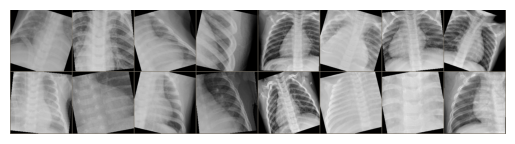

In [6]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[image_datasets['train'].classes[x] for x in classes])
plt.show()

Model Setup with Transfer Learning

In [7]:
# Load pretrained ResNet-18
model = models.resnet18(weights='DEFAULT')

In [8]:
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Freezing the parameters of the pretrained model allows the model to leverage the learned features from the ImageNet dataset
# effectively, preventing overfitting, speed up training, and focus on adapting the model to a new task. 

In [12]:
# Modify final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 output classes 'PNEUMONIA' and 'NORMAL'

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

Using device: cuda:0


In [50]:
# we modify the final layer to customize the pretrained model to our specific task
# and here we can leverage the the learned features from the pretrained model
# while adapting to our specific task.

In [51]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Cross Entropy Loss measures the difference between the predicted probability distribution (output of the model) 
# and the true distribution (actual labels). It quantifies how well the predicted probabilities match the true class labels.

Base Model

In [52]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc

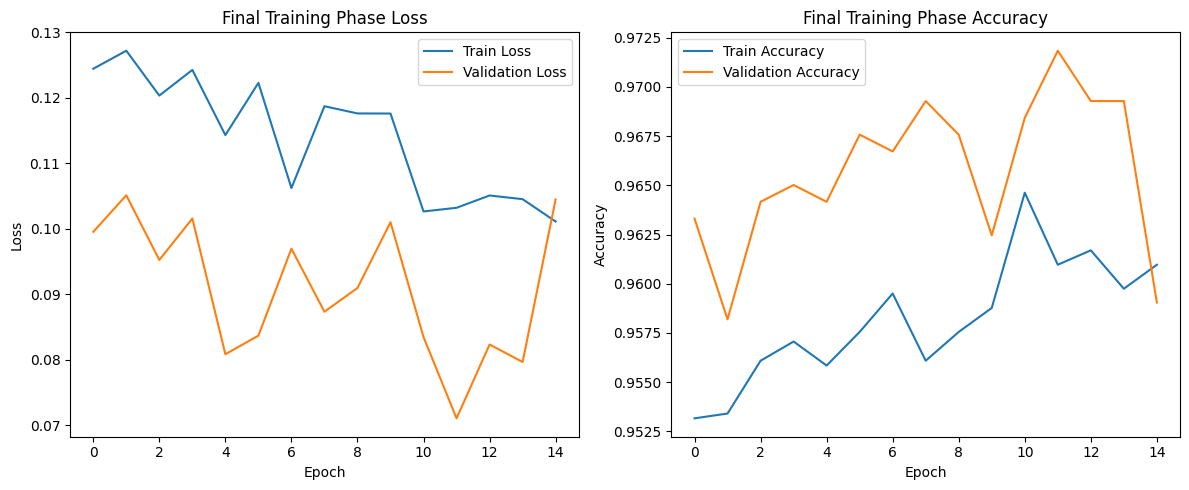

In [ ]:
# Visualize only the final training phase
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Training Phase Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot([x.cpu().numpy() for x in train_acc], label='Train Accuracy')
plt.plot([x.cpu().numpy() for x in val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Final Training Phase Accuracy')

plt.tight_layout()
plt.show()

In [34]:
# Looking at the graph, we can see that the base model is converging well, which indicates that the model is learning or generalizingwell.
# Though, we can still fluctuations, these indicates that the model is overfitting.

# Which we can improve by fine tuning it.

Fine Tuning

With a pretrained model, fine tuning and unfreezing layers progressively helps prevent overfitting and "forgetting". When the model is not fine tuned nor trained progressively, the model losses its general features learned from the pretrained model. With gradual unfreezing of layers, it allows the model to retain useful features while adapting to the new task.

In [9]:
# Load pretrained ResNet-18
model = models.resnet18(weights='DEFAULT')

In [10]:
# Freeze all layers except final FC layer
for param in model.parameters():
    param.requires_grad = False

In [13]:
# Modify final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

Using device: cuda:0


In [14]:
# Loss function optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            # Update schedulers AFTER phase completion
            if phase == 'train' and scheduler:
                if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    pass  
                else:
                    scheduler.step()

            if phase == 'val' and isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_acc)  # Update based on validation accuracy
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            # Append loss and accuracy to lists
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        epoch_time = time.time() - epoch_start
        print(f'Epoch complete in {epoch_time:.0f}s\n')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc

Train initial model

In [26]:
# Train only the final layer (classifier) while keeping the rest of the model frozen. This allows the model to 
# learn the new task's output space without altering the learned features.

model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, criterion, optimizer, num_epochs=10
)

Epoch 1/10
train Loss: 0.1151 Acc: 0.9554
val Loss: 0.0922 Acc: 0.9633
Epoch complete in 15s

Epoch 2/10
train Loss: 0.1229 Acc: 0.9544
val Loss: 0.0827 Acc: 0.9684
Epoch complete in 15s

Epoch 3/10
train Loss: 0.1165 Acc: 0.9573
val Loss: 0.0816 Acc: 0.9659
Epoch complete in 15s

Epoch 4/10
train Loss: 0.1126 Acc: 0.9593
val Loss: 0.0870 Acc: 0.9642
Epoch complete in 17s

Epoch 5/10
train Loss: 0.1206 Acc: 0.9529
val Loss: 0.0998 Acc: 0.9633
Epoch complete in 18s

Epoch 6/10
train Loss: 0.1230 Acc: 0.9546
val Loss: 0.0997 Acc: 0.9616
Epoch complete in 20s

Epoch 7/10
train Loss: 0.1340 Acc: 0.9473
val Loss: 0.0839 Acc: 0.9642
Epoch complete in 19s

Epoch 8/10
train Loss: 0.1189 Acc: 0.9532
val Loss: 0.1012 Acc: 0.9608
Epoch complete in 20s

Epoch 9/10
train Loss: 0.1175 Acc: 0.9576
val Loss: 0.0765 Acc: 0.9667
Epoch complete in 20s

Epoch 10/10
train Loss: 0.1201 Acc: 0.9573
val Loss: 0.0865 Acc: 0.9650
Epoch complete in 20s



Train intermediate model

In [27]:
# Unfreeze some of the later layers and train them with a smaller learning rate. This helps the model adjust 
# the more task-specific features to the new data.

# Unfreeze layer3 and layer4
for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name:
        param.requires_grad = True

# Use smaller LR for unfrozen layers
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,  # 10x smaller than initial
    weight_decay=1e-5  # Added regularization
)


In [28]:
# Add learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=3, 
    gamma=0.1
)

In [19]:
# Train intermediate model
model, train_loss_ft1, val_loss_ft1, train_acc_ft1, val_acc_ft1 = train_model(
    model, criterion, optimizer, scheduler, num_epochs=8
)

Epoch 1/8
train Loss: 0.2903 Acc: 0.8924
val Loss: 0.1760 Acc: 0.9309
Epoch complete in 18s

Epoch 2/8
train Loss: 0.2372 Acc: 0.9088
val Loss: 0.1324 Acc: 0.9462
Epoch complete in 17s

Epoch 3/8
train Loss: 0.2009 Acc: 0.9205
val Loss: 0.1050 Acc: 0.9548
Epoch complete in 17s

Epoch 4/8
train Loss: 0.1710 Acc: 0.9339
val Loss: 0.1164 Acc: 0.9539
Epoch complete in 17s

Epoch 5/8
train Loss: 0.1601 Acc: 0.9400
val Loss: 0.1240 Acc: 0.9497
Epoch complete in 17s

Epoch 6/8
train Loss: 0.1556 Acc: 0.9410
val Loss: 0.0897 Acc: 0.9633
Epoch complete in 17s

Epoch 7/8
train Loss: 0.1467 Acc: 0.9463
val Loss: 0.0902 Acc: 0.9616
Epoch complete in 18s

Epoch 8/8
train Loss: 0.1527 Acc: 0.9419
val Loss: 0.1022 Acc: 0.9531
Epoch complete in 17s



Full Fine-Tuning (All Layers)

In [29]:
# Unfreeze all layers and train the entire model with an even smaller learning rate. This allows the model to 
# fine-tune all features, including the general ones, to better fit the new task.

# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

In [30]:
# Very small LR with plateau-based scheduling
optimizer_ft = optim.Adam(
    model.parameters(),
    lr=0.00001,  # 100x smaller than initial
    weight_decay=1e-5
)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, 
    mode='max', 
    patience=2,
    factor=0.5,
    min_lr=1e-7,
    verbose=True
)

In [31]:
# Final training phase
model_ft, train_loss_ft2, val_loss_ft2, train_acc_ft2, val_acc_ft2 = train_model(
    model, criterion, optimizer_ft, scheduler_ft, num_epochs=15
)

Epoch 1/15
train Loss: 0.1244 Acc: 0.9532
val Loss: 0.0995 Acc: 0.9633
Epoch complete in 20s

Epoch 2/15
train Loss: 0.1272 Acc: 0.9534
val Loss: 0.1051 Acc: 0.9582
Epoch complete in 20s

Epoch 3/15
train Loss: 0.1203 Acc: 0.9561
val Loss: 0.0952 Acc: 0.9642
Epoch complete in 20s

Epoch 4/15
train Loss: 0.1243 Acc: 0.9571
val Loss: 0.1016 Acc: 0.9650
Epoch complete in 20s

Epoch 5/15
train Loss: 0.1143 Acc: 0.9558
val Loss: 0.0808 Acc: 0.9642
Epoch complete in 20s

Epoch 6/15
train Loss: 0.1223 Acc: 0.9576
val Loss: 0.0837 Acc: 0.9676
Epoch complete in 20s

Epoch 7/15
train Loss: 0.1062 Acc: 0.9595
val Loss: 0.0970 Acc: 0.9667
Epoch complete in 21s

Epoch 8/15
train Loss: 0.1187 Acc: 0.9561
val Loss: 0.0873 Acc: 0.9693
Epoch complete in 19s

Epoch 9/15
train Loss: 0.1176 Acc: 0.9576
val Loss: 0.0910 Acc: 0.9676
Epoch complete in 19s

Epoch 10/15
train Loss: 0.1176 Acc: 0.9588
val Loss: 0.1010 Acc: 0.9625
Epoch complete in 19s

Epoch 11/15
train Loss: 0.1026 Acc: 0.9646
val Loss: 0.0834

Visualization for all training phases

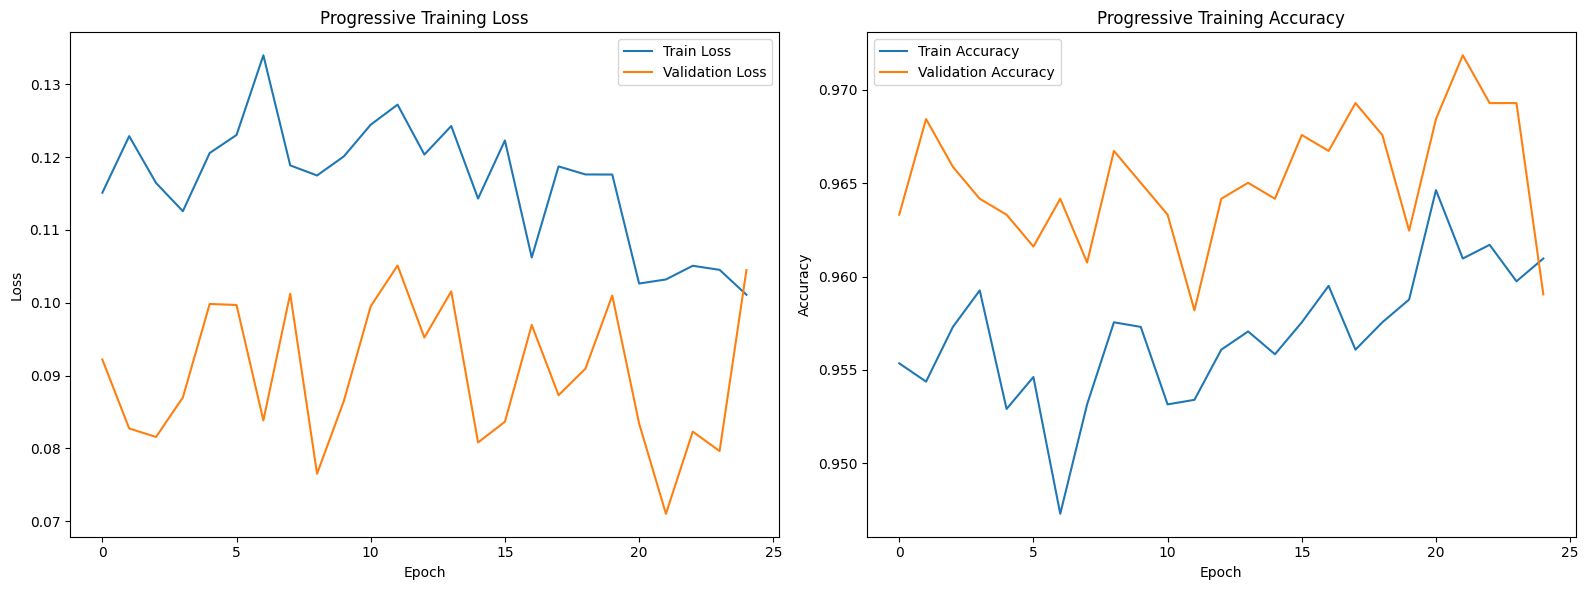

In [48]:
# Combine all training phases
all_train_loss = train_loss + train_loss_ft1 + train_loss_ft2
all_val_loss = val_loss + val_loss_ft1 + val_loss_ft2
all_train_acc = train_acc + train_acc_ft1 + train_acc_ft2
all_val_acc = val_acc + val_acc_ft1 + val_acc_ft2

plt.figure(figsize=(16, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Progressive Training Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot([x.cpu().numpy() for x in all_train_acc], label='Train Accuracy')
plt.plot([x.cpu().numpy() for x in all_val_acc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Progressive Training Accuracy')

plt.tight_layout()
plt.show()

In [1]:
# Here we can see the overall training and validation loss and accuracy of the model.
# Although there is a slight overfitting, the model is able to generalize well.
# This is evident from the validation loss and accuracy are close to the training loss and accuracy.

Model Evaluation on Test Set

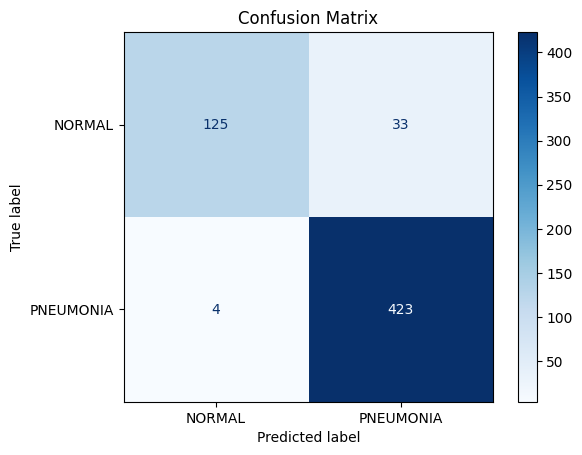

In [35]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Get predictions and true labels
y_pred, y_true = evaluate_model(model, dataloaders['test'])

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=image_datasets['train'].classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [4]:
# The model showed 93% accuracy on the test set. 
# TP: 423
# TN: 125
# FP: 33
# FN: 4
# This shows that the model is able to correctly predict a high number of both normal and pneumonia for unseen cases.
# This indicates good accuracy from the test set.